<a href="https://colab.research.google.com/github/AshSama12/EfficientNet/blob/master/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Install p7zip in case Kaggle package uses 7z archives
!apt-get update -qq
!apt-get install -y -qq p7zip-full

# Install kaggle CLI
!pip install -q kaggle


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [16]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Load CIFAR-10 via tf.keras.datasets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("Train:", x_train.shape, y_train.shape, "Test:", x_test.shape, y_test.shape)


TensorFlow version: 2.19.0
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Train: (50000, 32, 32, 3) (50000, 1) Test: (10000, 32, 32, 3) (10000, 1)


In [19]:
# Download CIFAR-10 competition files
!kaggle competitions download -c cifar-10 -p /content/cifar_kaggle
!ls -la /content/cifar_kaggle

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
ls: cannot access '/content/cifar_kaggle': No such file or directory


In [22]:
%%bash
cd /content/cifar_kaggle
ls -la

# If you see train.7z / test.7z files, extract them
if [ -f train.7z ]; then
  7z x train.7z -o./train_extracted
fi

if [ -f test.7z ]; then
  7z x test.7z -o./test_extracted
fi

total 16
drwxr-xr-x 1 root root 4096 Oct 21 16:52 .
drwxr-xr-x 1 root root 4096 Oct 23 07:47 ..
drwxr-xr-x 4 root root 4096 Oct 21 16:51 .config
drwxr-xr-x 1 root root 4096 Oct 21 16:52 sample_data


bash: line 1: cd: /content/cifar_kaggle: No such file or directory


In [26]:
!ls -R /content/cifar_kaggle


/content/cifar_kaggle:
train_images_by_class

/content/cifar_kaggle/train_images_by_class:


In [30]:
from tensorflow.keras.datasets import cifar10
import tensorflow as tf

# Automatically downloads & caches dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert to tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(128)
test_ds  = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128)

print(x_train.shape, x_test.shape)


(50000, 32, 32, 3) (10000, 32, 32, 3)


In [31]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

# Base model (pretrained on ImageNet, excluding top classifier)
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
base_model.trainable = False  # freeze for transfer learning

# Add custom classifier for CIFAR-10 (10 classes)
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1, 1, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [32]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 60s 87ms/step - accuracy: 0.0994 - loss: 2.3333 - val_accuracy: 0.1000 - val_loss: 2.3042
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1019 - loss: 2.3270 - val_accuracy: 0.1000 - val_loss: 2.3111
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1057 - loss: 2.3223 - val_accuracy: 0.1118 - val_loss: 2.3065
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1000 - loss: 2.3228 - val_accuracy: 0.1001 - val_loss: 2.3105
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1035 - loss: 2.3240 - val_accuracy: 0.1000 - val_loss: 2.3174
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1024 - loss: 2.3196 - val_accuracy: 0.1000 - val_loss: 2.3122
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1092 - loss: 2.3166 - val_accuracy: 0.1000 - val_loss: 2.3072
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1068 - loss: 2.3192 - val_accurac

In [33]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc*100:.2f}%")

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1027 - loss: 2.3051
Test accuracy: 10.00%


In [34]:
from tensorflow.keras.applications import EfficientNetB1, EfficientNetB2

# Try a bigger version (scaled-up EfficientNet)
scaled_model = EfficientNetB1(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
scaled_model.trainable = False

model_scaled = models.Sequential([
    layers.Resizing(64, 64),   # upscale CIFAR-10 images
    scaled_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

model_scaled.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_scaled.summary()

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb1 (Functional)     │ (None, 2, 2, 1280)     │     6,575,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,575,239 (25.08 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,575,239 (25.08 MB)

In [35]:
history_scaled = model_scaled.fit(train_ds.map(lambda x, y: (tf.image.resize(x, (64, 64)), y)),
                                  validation_data=test_ds.map(lambda x, y: (tf.image.resize(x, (64, 64)), y)),
                                  epochs=10)


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 135ms/step - accuracy: 0.1002 - loss: 2.3588 - val_accuracy: 0.1147 - val_loss: 2.3157
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.0983 - loss: 2.3371 - val_accuracy: 0.1019 - val_loss: 2.3103
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.1071 - loss: 2.3262 - val_accuracy: 0.1048 - val_loss: 2.3080
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.1059 - loss: 2.3240 - val_accuracy: 0.1041 - val_loss: 2.3074
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.1090 - loss: 2.3186 - val_accuracy: 0.1009 - val_loss: 2.3072
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.1073 - loss: 2.3200 - val_accuracy: 0.1350 - val_loss: 2.2923
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.1102 - loss: 2.3183 - val_accuracy: 0.1085 - val_loss: 2.2925
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.1128 - loss: 2.3149 -

In [36]:
print("Baseline EfficientNetB0 Accuracy:", test_acc)
print("Scaled EfficientNetB1 Accuracy:", model_scaled.evaluate(
      test_ds.map(lambda x, y: (tf.image.resize(x, (64, 64)), y)))[1])


Baseline EfficientNetB0 Accuracy: 0.10000000149011612
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.1264 - loss: 2.2998
Scaled EfficientNetB1 Accuracy: 0.12700000405311584


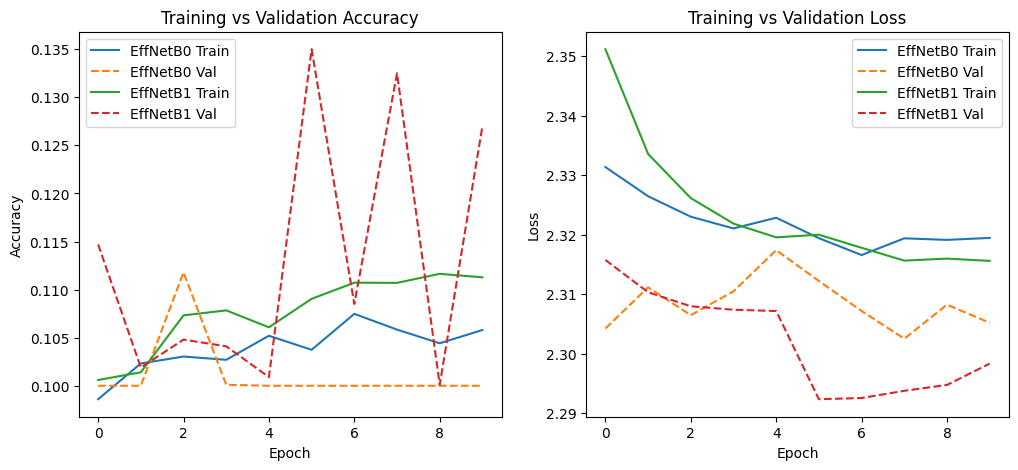

In [37]:
import matplotlib.pyplot as plt

def plot_training_history(history1, history2=None, labels=['Baseline', 'Scaled']):
    """
    history1: History object from model.fit() for baseline
    history2: History object from model.fit() for scaled model (optional)
    labels: list of labels for the legend
    """
    # Accuracy plot
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history1.history['accuracy'], label=f'{labels[0]} Train')
    plt.plot(history1.history['val_accuracy'], '--', label=f'{labels[0]} Val')
    if history2:
        plt.plot(history2.history['accuracy'], label=f'{labels[1]} Train')
        plt.plot(history2.history['val_accuracy'], '--', label=f'{labels[1]} Val')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history1.history['loss'], label=f'{labels[0]} Train')
    plt.plot(history1.history['val_loss'], '--', label=f'{labels[0]} Val')
    if history2:
        plt.plot(history2.history['loss'], label=f'{labels[1]} Train')
        plt.plot(history2.history['val_loss'], '--', label=f'{labels[1]} Val')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Example usage: compare baseline vs scaled
plot_training_history(history, history_scaled, labels=['EffNetB0', 'EffNetB1'])


In [38]:
import numpy as np
import time

def measure_inference_time(model, input_shape=(32,32,3), batch_size=1, n_runs=30):
    dummy = np.random.rand(batch_size, *input_shape).astype('float32')
    # Warmup
    _ = model.predict(dummy, batch_size=batch_size)
    times = []
    for _ in range(n_runs):
        t0 = time.time()
        _ = model.predict(dummy, batch_size=batch_size)
        times.append(time.time() - t0)
    avg = np.mean(times)
    return avg / batch_size

# Measure for baseline
time_baseline = measure_inference_time(model, input_shape=(32,32,3))
time_scaled   = measure_inference_time(model_scaled, input_shape=(64,64,3))

print(f"Baseline (B0, 32x32) Inference time per image: {time_baseline*1000:.2f} ms")
print(f"Scaled   (B1, 64x64) Inference time per image: {time_scaled*1000:.2f} ms")


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━